In [236]:
import glob
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiskit

import qcopt
from compute_and_store_expectation_value import get_output_dist_dict

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

# Data loading

In [2]:
def get_pickles(N, P, graph_type, verbose=0):
    print(f'LOADING QAOA+ P{P}_N{N}_{graph_type}')
        
    retval = []
    
    base_path = f'benchmark_results/QAOA+_P{P}_qasm/N{N}_{graph_type}_graphs/'
    graph_dirs = glob.glob(base_path + '*')

    if verbose:
        print('base path:', base_path)
        print(f'Loaded results for {len(graph_dirs)} graphs')
    
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-1].strip('G')))
    
    for gd in graph_dirs:
        all_reps = glob.glob(gd+'/*.pickle')
        if verbose and len(all_reps) != 5:
              print(f'\tOnly loaded {len(all_reps)} reps from {gd}')
        
        graphfn = f'benchmark_graphs/N{N}_{graph_type}_graphs/{gd.split("/")[-1]}.txt'

        G = qcopt.graph_funcs.graph_from_file(graphfn)
        graph_name = f'N{N}_{graph_type}_{gd.split("/")[-1]}'
        
        temp_pickles = []
        for pklfile in all_reps:
            with open(pklfile, 'rb') as pf:
                res = pickle.load(pf)
                temp_pickles.append((pklfile.split('_')[-1].strip('.pickle'), res))
                
        # Collect the extra lambda data if available
        all_extra_reps = glob.glob(gd+'/extra_lambda/*pickle')
        for pklfile in all_extra_reps:
            with open(pklfile, 'rb') as pf:
                res = pickle.load(pf)
                temp_pickles.append((pklfile.split('_')[-1].strip('.pickle') + '_extra', res))

        # after collecting reps for this graph, store the results
        retval.append((G, temp_pickles, graph_name))
            
    return retval

# Plot optimized distributions

## Approximation ratio (best valid bitstring >50%)
Larkin et. al. in "Evaluation of QAOA based on the approximation ratio of individual samples" state that

> However, the objective that guides such optimization is an expectation value averaged over multiple candidate solutions. Most studies relied on concentration arguments to report the average value instead of the best single outcome. In this work, given a desired approximation ratio, we formulate the performance of QAOA as the time needed before at least one sample with approximation ratio above the desired threshold is observed with probability at least 50%

From this, we can choose to present our QAOA+ results as achieving an approximation ratio equal to that given by the largest Hamming weight bitstring which is also a valid IS with probabily >50%.

## Approximation ratio (theory result: $\langle E \rangle$)
First load in the data: its csv entry and corresponding output pickles

In [56]:
def get_row_data(lamda, p, N, graph_type, graph_name, rep_name):
    df = pd.read_csv("benchmark_results/QAOA+_expectation_values/all_d3_data.csv", usecols=[1,2,3,4,5,6,7])
    df.drop_duplicates(inplace=True)
    
    row_data = df.loc[(df['lambda'] == lamda) & (df['p'] == p) & (df['N'] == N) & (df['graph_type'] == graph_type) & \
                      (df['graph_name'] == graph_name) & (df['rep_name'] == rep_name)]
    
    print(row_data['lambda'])
    
    dirname = f"benchmark_results/QAOA+_output_distributions/P{p}_{graph_type}/{graph_name}_{rep_name}"
    with open(f"{dirname}/hamming_histogram_lambda_{lamda}.pickle", "rb") as pklfile:
        hamming_histogram = pickle.load(pklfile)
    with open(f"{dirname}/top_100strings_lambda_{lamda}.pickle", "rb") as pklfile:
        top_strings = pickle.load(pklfile)
        
    # For the top strings we have to go through and label them as valid and invalid MIS states
    G = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N{N}_{graph_type}_graphs/{graph_name}.txt")
    top_strings_w_bool = []
    for bitstr, probability in top_strings:
        top_strings_w_bool.append((bitstr, probability, qcopt.graph_funcs.is_indset(bitstr, G)))

    return row_data, hamming_histogram, top_strings_w_bool

def get_expectation_data(df, p, N, graph_type):
    cur_data = df.loc[(df['p'] == p) & (df['N'] == N) & (df['graph_type'] == graph_type)]

    xvals = sorted(list(set(cur_data['lambda'])))
    yvals, stderr = [], []
    for lambda_val in xvals:
        ldf = cur_data.loc[cur_data['lambda'] == lambda_val]
        yvals.append(np.mean(ldf['expectation_value']))
        stderr.append(np.std(ldf['expectation_value']) / np.sqrt(len(ldf['expectation_value'])))
    
    return xvals, yvals, stderr

def plot_raw_expectation_value(data_dict, savefig=None, zoom=True):
    fig, ax = plt.subplots(dpi=200)
    
    for data in data_dict:
        ax.errorbar(data['xvals'], [y/20 for y in data['yvals']], yerr=[e/20 for e in data['stderr']],
                    label=data['label'], elinewidth=1, capsize=1)
    
    ax.legend()
    
    if zoom:
        ax.set_xlim([0,3])
        ax.set_ylim([0,1])
    
    ax.set_ylabel(r'$\frac{\langle E \rangle}{N}$')
    ax.set_xlabel('$\lambda$')
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

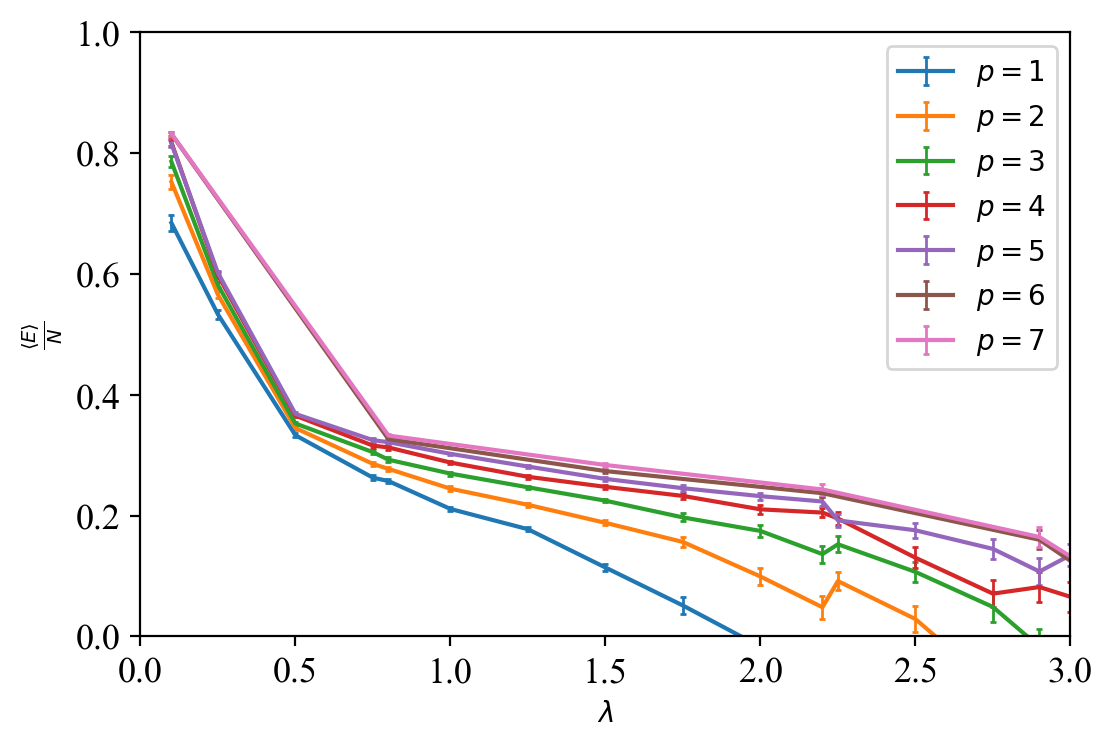

In [52]:
df = pd.read_csv("benchmark_results/QAOA+_expectation_values/all_d3_data.csv", usecols=[1,2,3,4,5,6,7])
df.drop_duplicates(inplace=True)

raw_expectation_value_data = []
for p in [1,2,3,4,5,6,7]:
    lambdas, expect_vals, stderrs = get_expectation_data(df, p, 20, 'd3')
    raw_expectation_value_data.append({'xvals':lambdas, 'yvals':expect_vals, 'stderr':stderrs, 'label':f'$p = {p}$'})
plot_raw_expectation_value(raw_expectation_value_data)

### Paper plots

#### 3-regular

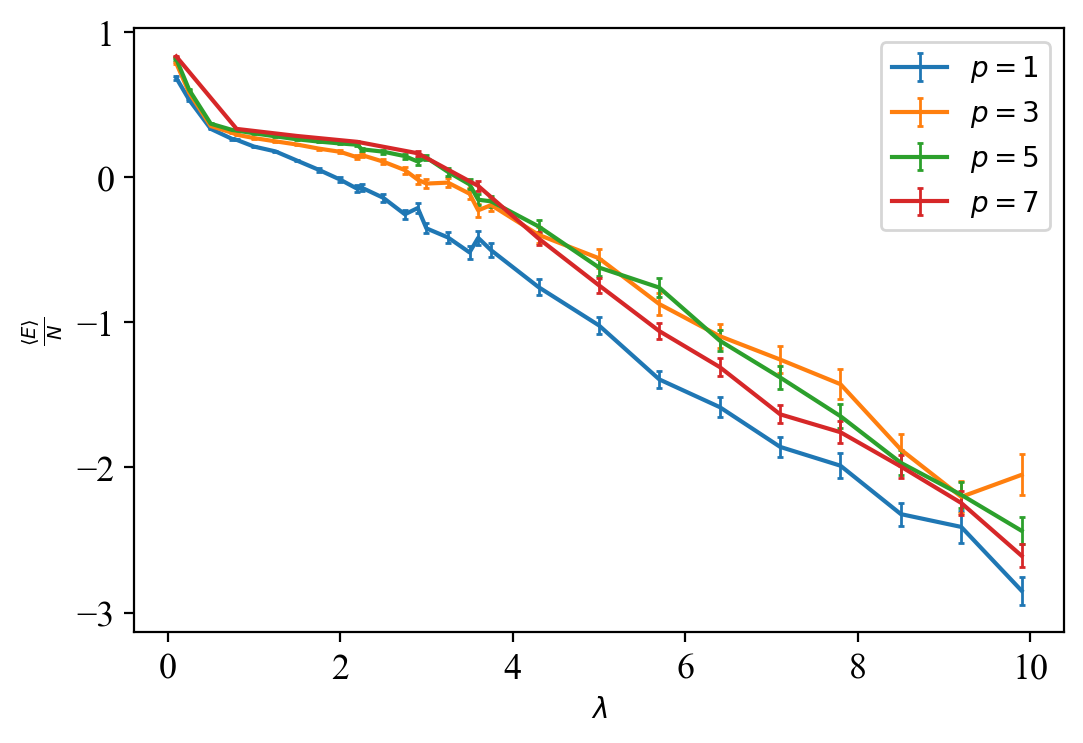

In [57]:
df = pd.read_csv("benchmark_results/QAOA+_expectation_values/all_d3_data.csv", usecols=[1,2,3,4,5,6,7])
df.drop_duplicates(inplace=True)

raw_expectation_value_data = []
for p in [1,3,5,7]:
    lambdas, expect_vals, stderrs = get_expectation_data(df, p, 20, 'd3')
    raw_expectation_value_data.append({'xvals':lambdas, 'yvals':expect_vals, 'stderr':stderrs, 'label':f'$p = {p}$'})
plot_raw_expectation_value(raw_expectation_value_data, savefig="figures/N20_d3_full_expectation_value.pdf", zoom=False)

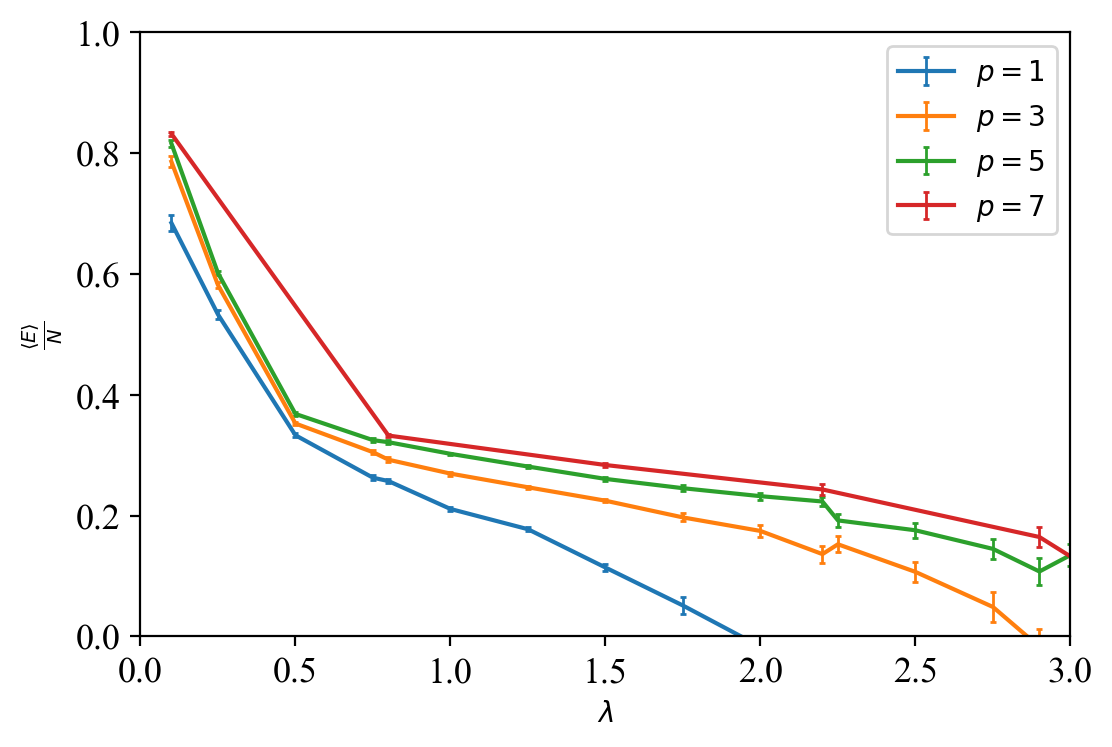

In [58]:
df = pd.read_csv("benchmark_results/QAOA+_expectation_values/all_d3_data.csv", usecols=[1,2,3,4,5,6,7])
df.drop_duplicates(inplace=True)

raw_expectation_value_data = []
for p in [1,3,5,7]:
    lambdas, expect_vals, stderrs = get_expectation_data(df, p, 20, 'd3')
    raw_expectation_value_data.append({'xvals':lambdas, 'yvals':expect_vals, 'stderr':stderrs, 'label':f'$p = {p}$'})
plot_raw_expectation_value(raw_expectation_value_data, savefig="figures/N20_d3_full_expectation_value_zoomed.pdf", zoom=True)

## Approximation ratio (valid bitstring with highest probability)

In [22]:
all_data = []
graph_type = 'd3'
graph_size = 20
for p in [1, 2, 3, 4, 5, 6, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N20_d3
LOADING QAOA+ P2_N20_d3
LOADING QAOA+ P3_N20_d3
LOADING QAOA+ P4_N20_d3
LOADING QAOA+ P5_N20_d3
LOADING QAOA+ P6_N20_d3
LOADING QAOA+ P7_N20_d3


In [31]:
def ar_valid_bitstring_with_highest_probability(all_data, savefig=None, verbose=0):
    fig, ax = plt.subplots(dpi=200)
    
    for P, graph_type, data in all_data:
        if verbose:
            print(f'Processing {len(data)} graphs for P={P} {graph_type} graphs')
            
        y_val_dict = {}
        for G, rep_data, graph_name in data:
            for rep_name, rep_output in rep_data:
                for data_dict in rep_output:
                    rounded_lambda = round(data_dict['lambda'], 3)
                    valid_most_likely_approx_ratio = data_dict['ratios'][1]
                    if rounded_lambda in y_val_dict.keys():
                        y_val_dict[rounded_lambda].append(valid_most_likely_approx_ratio)
                    else:
                        y_val_dict[rounded_lambda] = [valid_most_likely_approx_ratio]
        
        # Average over all graphs and all repetitions
        avg_y_val_dict = {key: (np.mean(val), np.std(val) / np.sqrt(len(val))) for key, val in y_val_dict.items()}
        sorted_keys = sorted(avg_y_val_dict.keys())
        ax.errorbar(sorted_keys, [avg_y_val_dict[key][0] for key in sorted_keys], yerr=[avg_y_val_dict[key][1] for key in sorted_keys],
                    label=f'$p={P}$', elinewidth=1, capsize=1)
    
    ax.legend()
    ax.set_ylabel('Approximation Ratio')
    ax.set_xlabel('$\lambda$')
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

Processing 30 graphs for P=1 d3 graphs
Processing 30 graphs for P=2 d3 graphs
Processing 30 graphs for P=3 d3 graphs
Processing 30 graphs for P=4 d3 graphs
Processing 30 graphs for P=5 d3 graphs
Processing 30 graphs for P=6 d3 graphs
Processing 30 graphs for P=7 d3 graphs


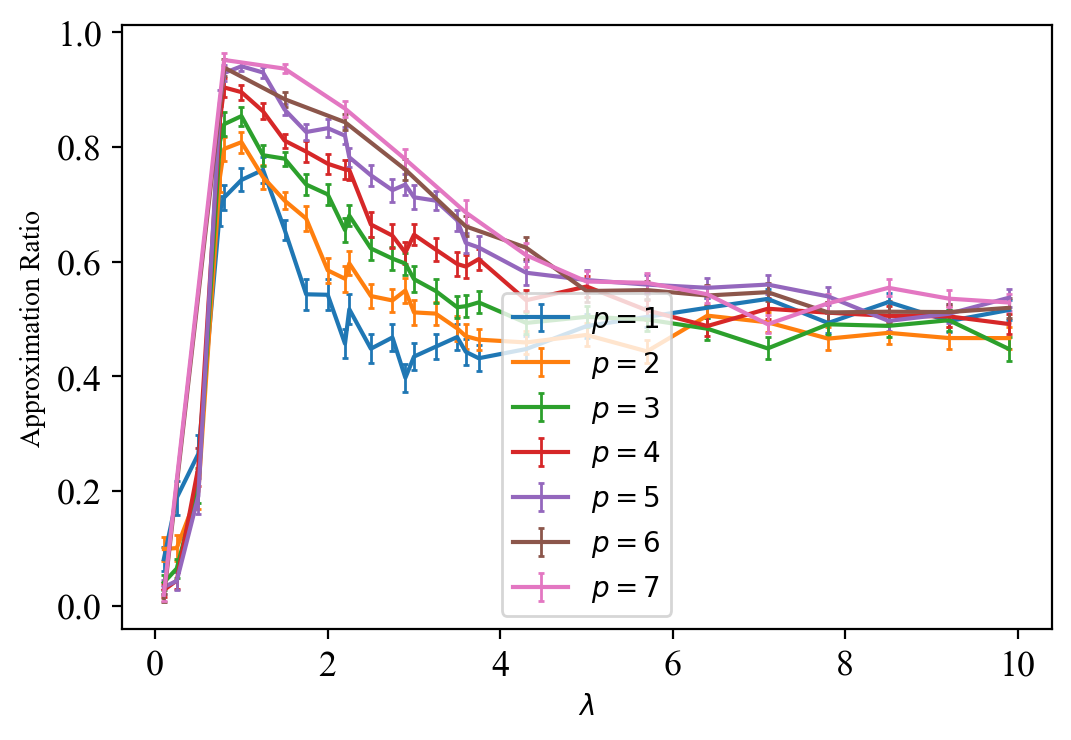

In [23]:
ar_valid_bitstring_with_highest_probability(all_data, verbose=1)

### Paper plots

#### 3-regular 20 nodes

In [32]:
all_data = []
graph_type = 'd3'
graph_size = 20
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N20_d3
LOADING QAOA+ P3_N20_d3
LOADING QAOA+ P5_N20_d3
LOADING QAOA+ P7_N20_d3


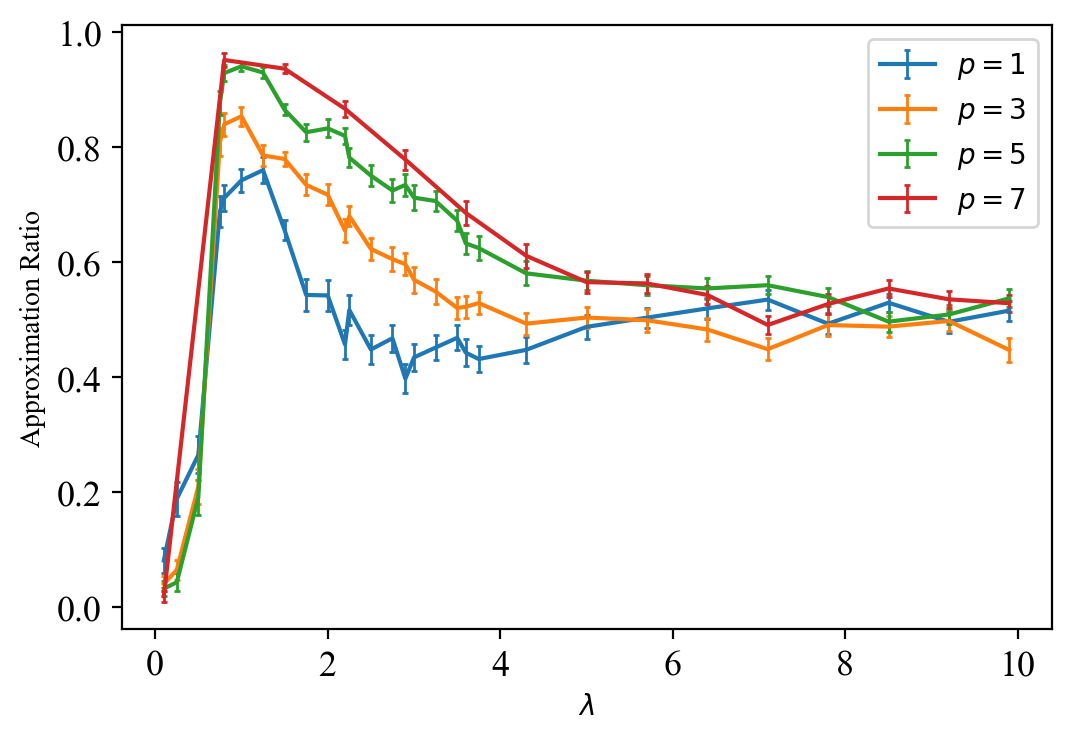

In [33]:
ar_valid_bitstring_with_highest_probability(all_data, savefig="figures/N20_d3_highestprob_approxratio.pdf")

#### 3-regular 10 nodes

In [34]:
all_data = []
graph_type = 'd3'
graph_size = 10
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N10_d3
LOADING QAOA+ P3_N10_d3
LOADING QAOA+ P5_N10_d3
LOADING QAOA+ P7_N10_d3


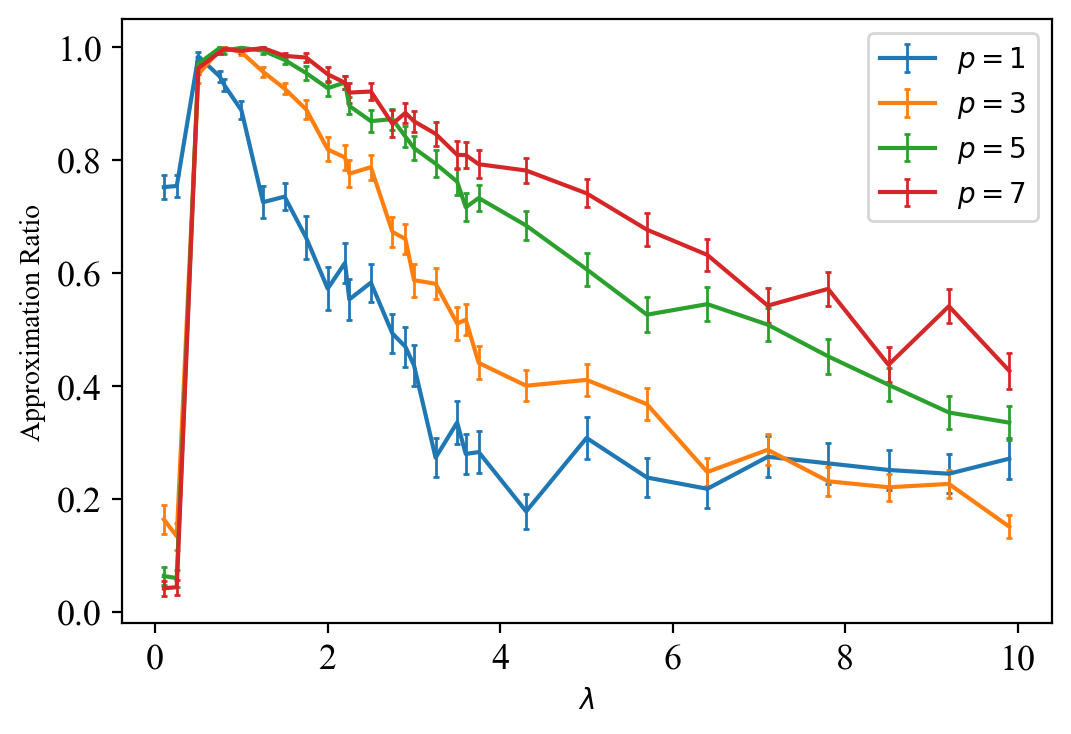

In [35]:
ar_valid_bitstring_with_highest_probability(all_data, savefig="figures/N10_d3_highestprob_approxratio.pdf")

#### Erdos-Renyi 20 nodes

In [36]:
all_data = []
graph_type = 'p50'
graph_size = 20
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N20_p50
LOADING QAOA+ P3_N20_p50
LOADING QAOA+ P5_N20_p50
LOADING QAOA+ P7_N20_p50


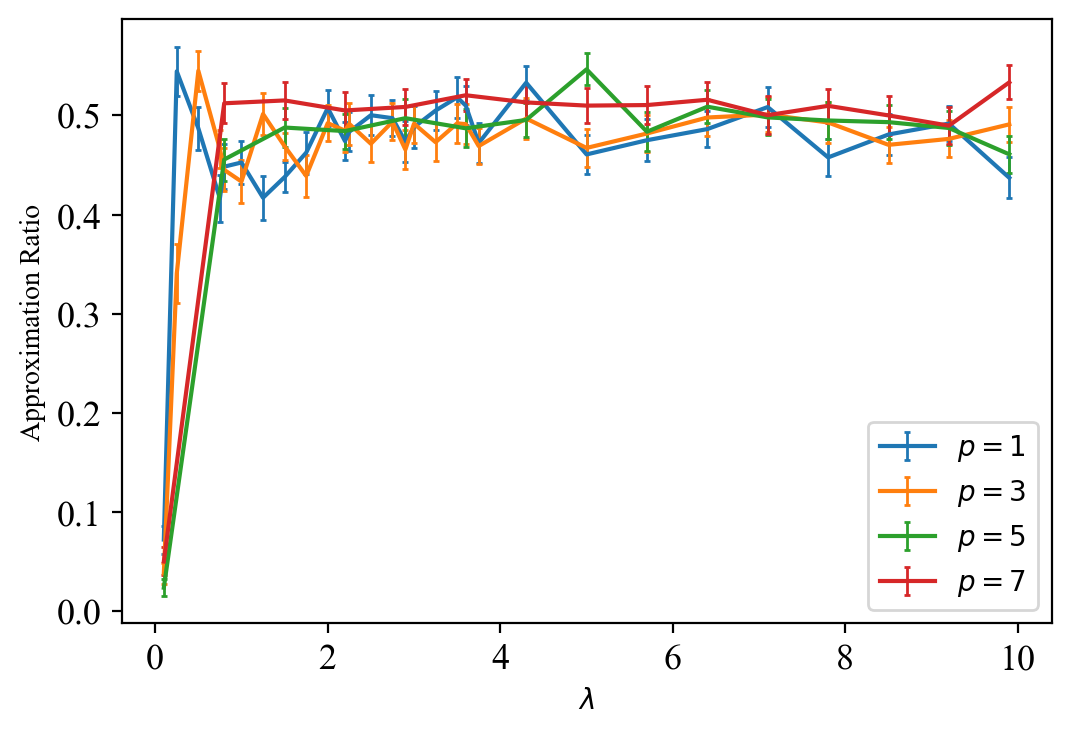

In [37]:
ar_valid_bitstring_with_highest_probability(all_data, savefig="figures/N20_p50_highestprob_approxratio.pdf")

#### Erdos-Renyi 10 nodes

In [38]:
all_data = []
graph_type = 'p50'
graph_size = 10
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N10_p50
LOADING QAOA+ P3_N10_p50
LOADING QAOA+ P5_N10_p50
LOADING QAOA+ P7_N10_p50


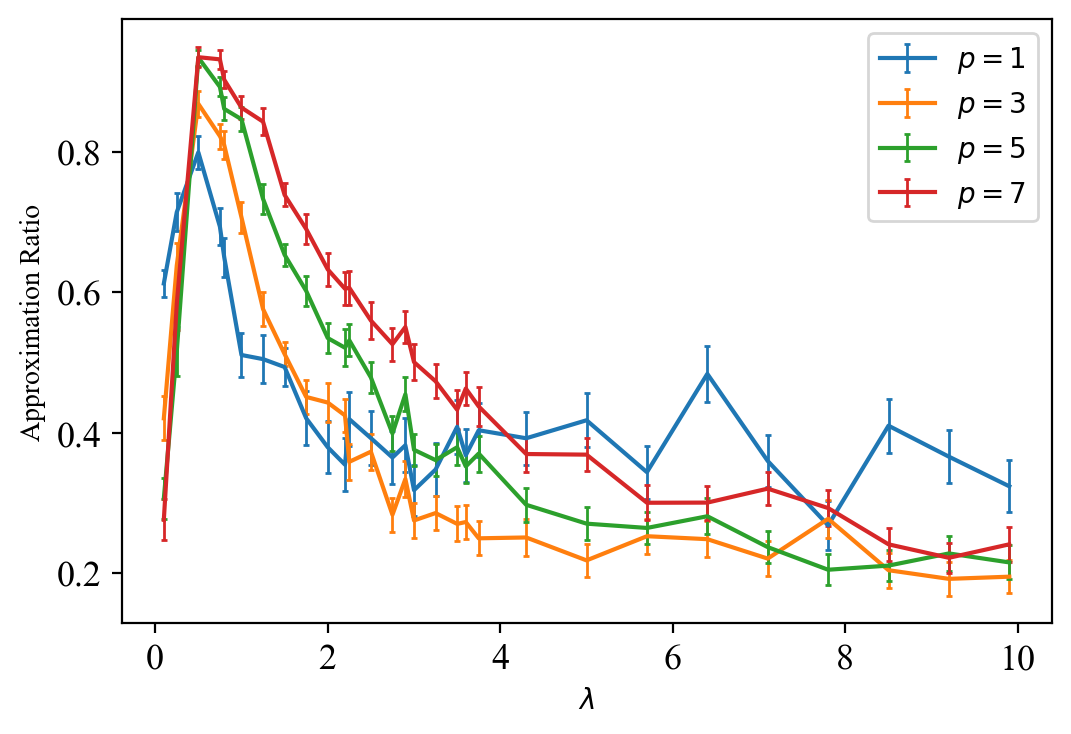

In [39]:
ar_valid_bitstring_with_highest_probability(all_data, savefig="figures/N10_p50_highestprob_approxratio.pdf")

## Approximiation ratio (over valid states only, scaled by all shots)

In [13]:
all_data = []
graph_type = 'd3'
graph_size = 10
for p in [1, 2, 3, 4, 5, 6, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N10_d3
LOADING QAOA+ P2_N10_d3
LOADING QAOA+ P3_N10_d3
LOADING QAOA+ P4_N10_d3
LOADING QAOA+ P5_N10_d3
LOADING QAOA+ P6_N10_d3
LOADING QAOA+ P7_N10_d3


In [40]:
def ar_valid_bitstrings_only(all_data, verbose=0, savefig=None):
    fig, ax = plt.subplots(dpi=200)
    
    for P, graph_type, data in all_data:
        if verbose:
            print(f'Processing {len(data)} graphs for P={P} {graph_type} graphs')
            
        y_val_dict = {}
        for G, rep_data, graph_name in data:
            for rep_name, rep_output in rep_data:
                for data_dict in rep_output:
                    rounded_lambda = round(data_dict['lambda'], 3)
                    eqn8_approx_ratio = data_dict['ratios'][0]
                    if rounded_lambda in y_val_dict.keys():
                        y_val_dict[rounded_lambda].append(eqn8_approx_ratio)
                    else:
                        y_val_dict[rounded_lambda] = [eqn8_approx_ratio]
        
        # Average over all graphs and all repetitions
        avg_y_val_dict = {key: (np.mean(val), np.std(val) / np.sqrt(len(val))) for key, val in y_val_dict.items()}
        sorted_keys = sorted(avg_y_val_dict.keys())
        ax.errorbar(sorted_keys, [avg_y_val_dict[key][0] for key in sorted_keys], yerr=[avg_y_val_dict[key][1] for key in sorted_keys],
                    label=f'$p={P}$', elinewidth=1, capsize=1)
    
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel(r'$E^f_p = \frac{\sum c_i H_i}{shots}$')
    
    ax.legend()
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

Processing 30 graphs for P=1 d3 graphs
Processing 30 graphs for P=2 d3 graphs
Processing 30 graphs for P=3 d3 graphs
Processing 30 graphs for P=4 d3 graphs
Processing 30 graphs for P=5 d3 graphs
Processing 30 graphs for P=6 d3 graphs
Processing 30 graphs for P=7 d3 graphs


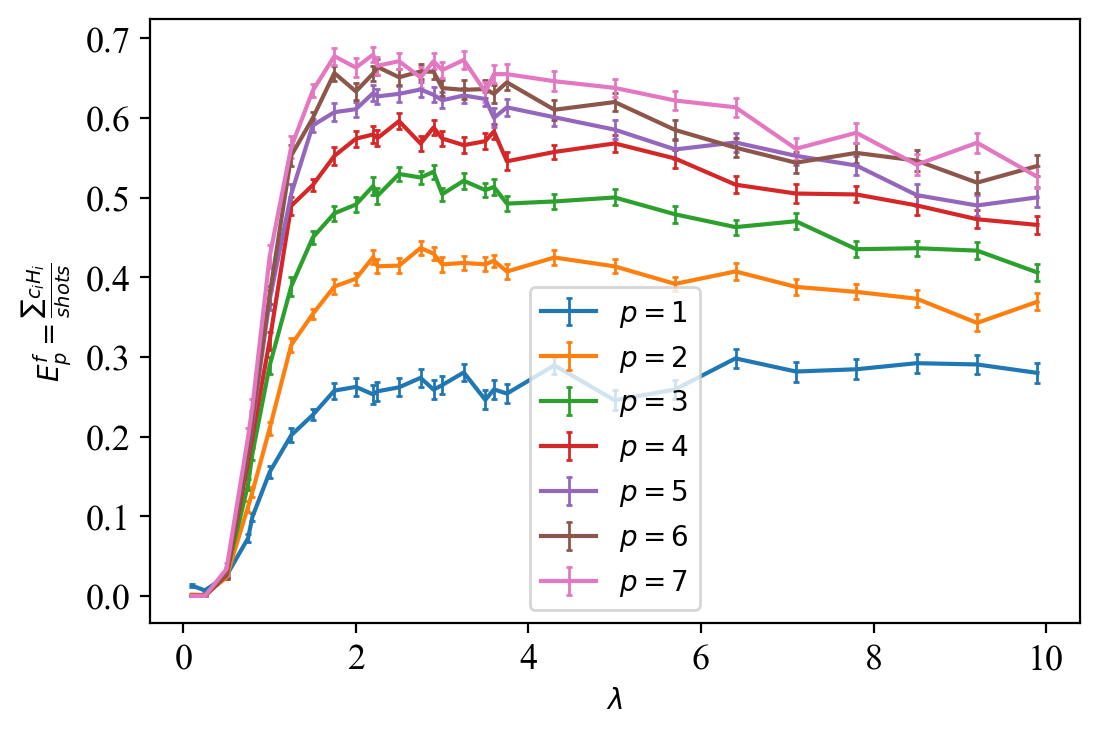

In [14]:
ar_valid_bitstrings_only(all_data, verbose=1)

### Paper plots

#### 3-regular 20 nodes

In [41]:
all_data = []
graph_type = 'd3'
graph_size = 20
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N20_d3
LOADING QAOA+ P3_N20_d3
LOADING QAOA+ P5_N20_d3
LOADING QAOA+ P7_N20_d3


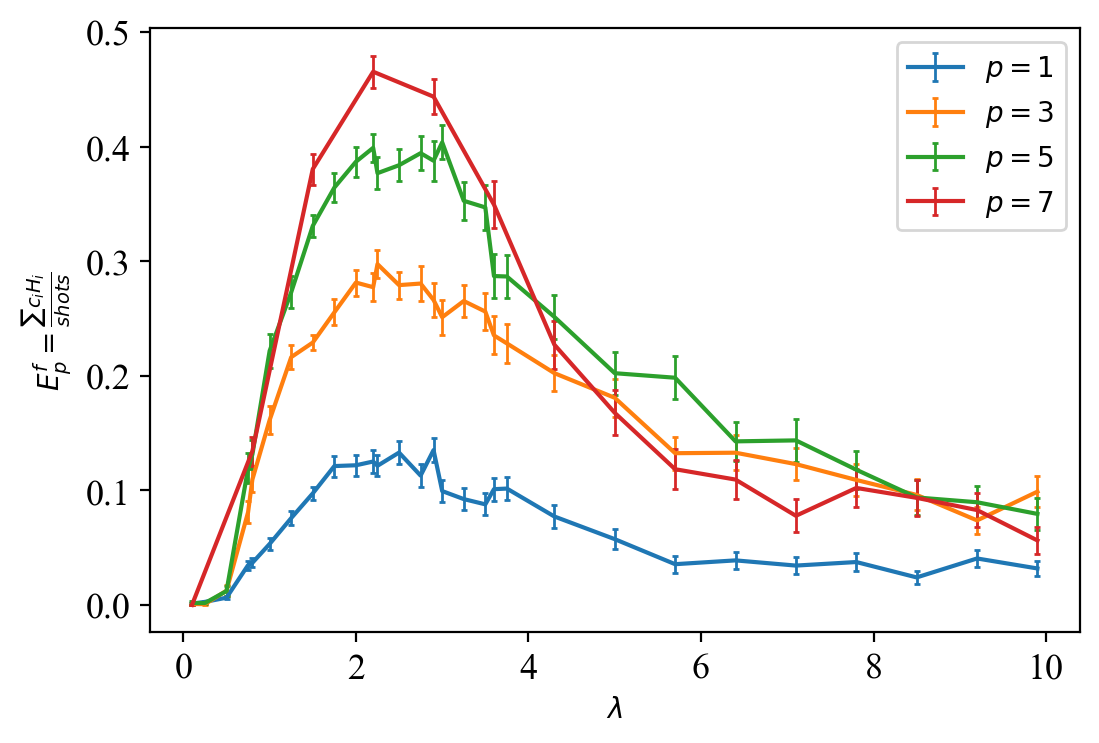

In [42]:
ar_valid_bitstrings_only(all_data, savefig="figures/N20_d3_scaled_expectation_value.pdf")

#### 3-regular 10 nodes

In [43]:
all_data = []
graph_type = 'd3'
graph_size = 10
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N10_d3
LOADING QAOA+ P3_N10_d3
LOADING QAOA+ P5_N10_d3
LOADING QAOA+ P7_N10_d3


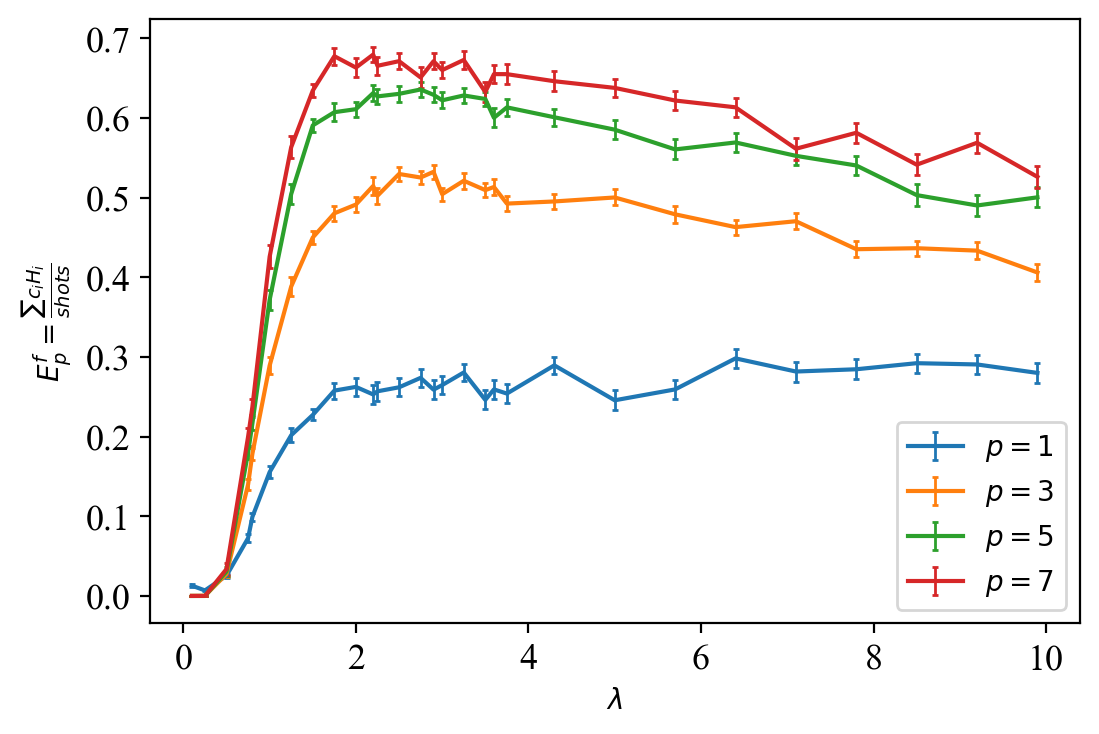

In [44]:
ar_valid_bitstrings_only(all_data, savefig=f"figures/N{graph_size}_{graph_type}_scaled_expectation_value.pdf")

#### Erdos-Renyi 20 nodes

In [45]:
all_data = []
graph_type = 'p50'
graph_size = 20
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N20_p50
LOADING QAOA+ P3_N20_p50
LOADING QAOA+ P5_N20_p50
LOADING QAOA+ P7_N20_p50


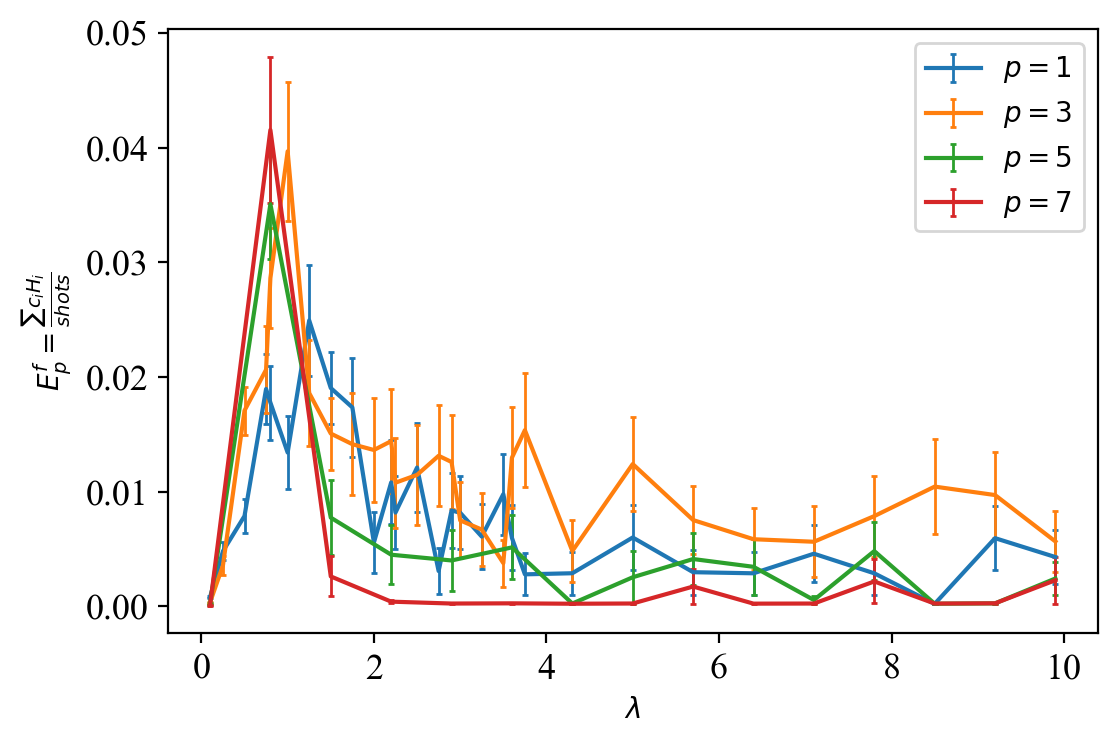

In [46]:
ar_valid_bitstrings_only(all_data, savefig=f"figures/N{graph_size}_{graph_type}_scaled_expectation_value.pdf")

#### Erdos-Renyi 10 nodes

In [47]:
all_data = []
graph_type = 'p50'
graph_size = 10
for p in [1, 3, 5, 7]:
    all_data.append((p, graph_type, get_pickles(graph_size, p, graph_type)))

LOADING QAOA+ P1_N10_p50
LOADING QAOA+ P3_N10_p50
LOADING QAOA+ P5_N10_p50
LOADING QAOA+ P7_N10_p50


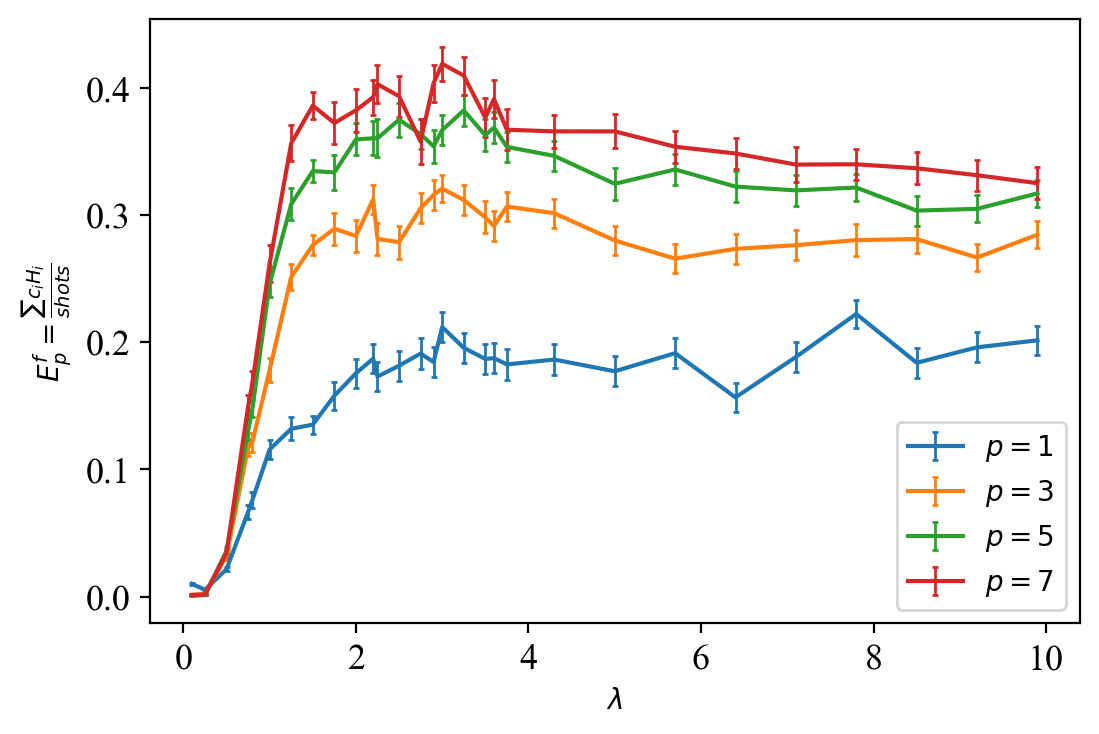

In [48]:
ar_valid_bitstrings_only(all_data, savefig=f"figures/N{graph_size}_{graph_type}_scaled_expectation_value.pdf")

## Distribution of valid and invalid states in optimized ansatzes

In [449]:
def get_row_data(row_data):
    lamda = row_data.iloc[0]['lambda']
    p = row_data.iloc[0]['p']
    graph_type = row_data.iloc[0]['graph_type']
    graph_name = row_data.iloc[0]['graph_name']
    rep_name = row_data.iloc[0]['rep_name']
    N = row_data.iloc[0]['N']
    
    dirname = f"benchmark_results/QAOA+_output_distributions/P{p}_{graph_type}_N{N}/{graph_name}_{rep_name}"
    with open(f"{dirname}/hamming_histogram_lambda_{lamda}.pickle", "rb") as pklfile:
        hamming_histogram = pickle.load(pklfile)
    with open(f"{dirname}/top_100strings_lambda_{lamda}.pickle", "rb") as pklfile:
        top_strings = pickle.load(pklfile)
        
    # For the top strings we have to go through and label them as valid and invalid MIS states
    G = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N{N}_{graph_type}_graphs/{graph_name}.txt")
    top_strings_w_bool = []
    for bitstr, probability in top_strings:
        top_strings_w_bool.append((bitstr, probability, qcopt.graph_funcs.is_indset(bitstr, G)))

    return hamming_histogram, top_strings_w_bool

def optimized_output_distribution(p, N, graph_type, graph_name, rep_name, verbose=0, savefig=None,
                                  limited_lambda=None):
    df = pd.read_csv("benchmark_results/QAOA+_expectation_values/all_d3_data.csv", usecols=[1,2,3,4,5,6,7])
    df.drop_duplicates(inplace=True)
    
    cur_data = df.loc[(df['p'] == p) & (df['N'] == N) & (df['graph_type'] == graph_type) & \
                      (df['graph_name'] == graph_name) & (df['rep_name'] == rep_name)]
    
    if limited_lambda:
        cur_data = cur_data[cur_data['lambda'].isin(limited_lambda)]

    xvals = sorted(list(set(cur_data['lambda'])))
    
    fig, axes = plt.subplots(figsize=[7,int(2*len(xvals))], nrows=len(xvals), ncols=1, sharex=True)
    
    for ax, lambda_val in zip(axes, xvals):
        row_data = cur_data.loc[cur_data['lambda'] == lambda_val]
        hamming_histogram, top_strings = get_row_data(row_data)
        
        #print(f'Lambda = {lambda_val}')
        #valid_sum = sum([v['valid'] for v in hamming_histogram.values()])
        #invalid_sum = sum([v['invalid'] for v in hamming_histogram.values()])
        #print(f"\tThe sum total probability of valid states: {valid_sum}")
        #print(f"\tThe sum total probability of invalid states: {invalid_sum}")
        
        hamming_weights = sorted(list(hamming_histogram.keys()))
        
        # Plot the invalid bars first, height = prob_valid + prob_invalid
        invalid_heights = [sum(hamming_histogram[hw].values()) for hw in hamming_weights]
        ax.bar(hamming_weights, invalid_heights, label='Invalid')
        
        # Plot the valid bars second (so they are in front), height = prob_valid
        valid_heights = [hamming_histogram[hw]['valid'] for hw in hamming_weights]
        ax.bar(hamming_weights, valid_heights, label='Valid')     
        
        ax.text(0.005, 0.8, f'$\lambda = {lambda_val}$', fontsize=16, horizontalalignment='left', transform=ax.transAxes)
        ax.text(0.005, 0.6, f'$<E> = {row_data.iloc[0]["expectation_value"]:.2f}$', fontsize=16, horizontalalignment='left', transform=ax.transAxes)
        ax.tick_params(axis='y', labelsize=18)
        ax.tick_params(axis='x', labelsize=18)
    
    axes[-1].legend(loc='upper right', fontsize=16)
    axes[-1].set_xlabel('Hamming weight', fontsize=18)
    axes[0].set_title(f'Output of $p={p}$ QAOA+ on a {N}-node, {graph_type.strip("d")}-regular graph', fontsize=17)
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

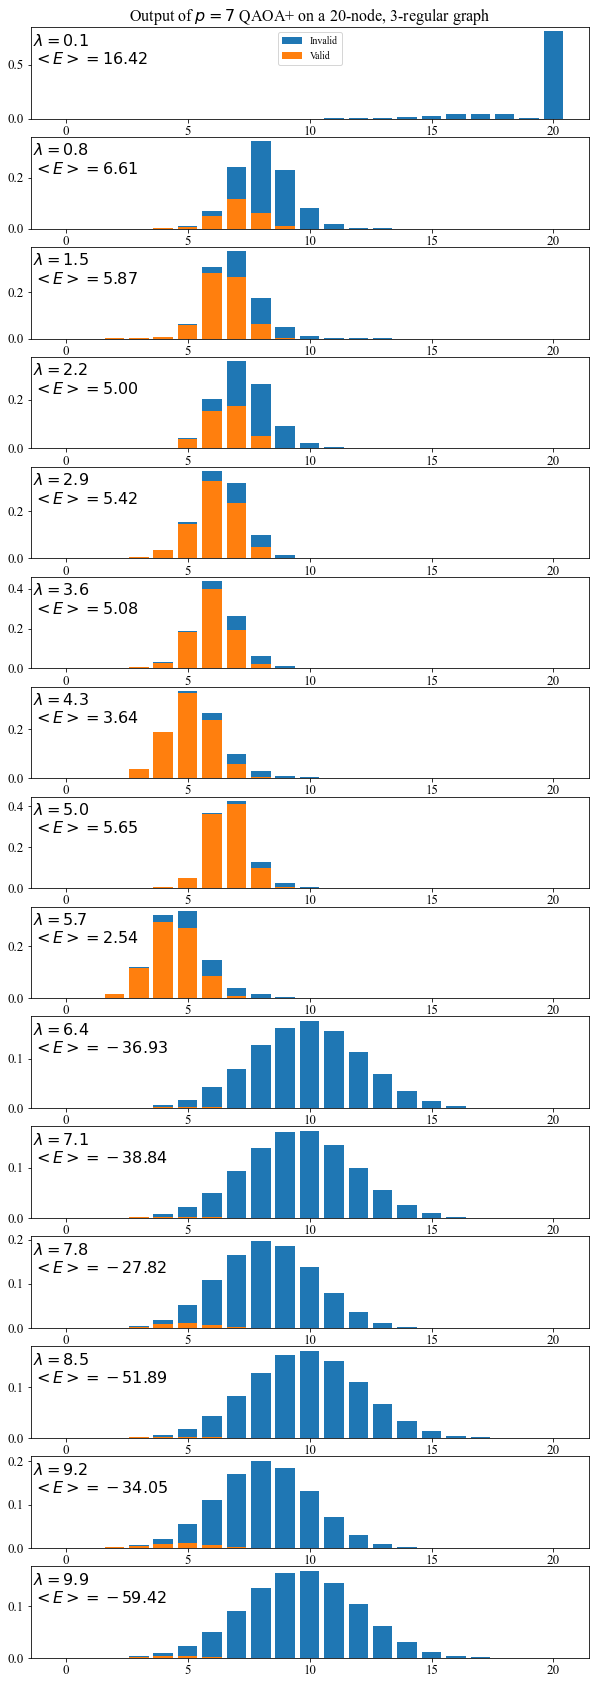

In [372]:
optimized_output_distribution(7, 20, 'd3', 'G12', 'rep5', verbose=1)

### Paper plots

#### 3-regular

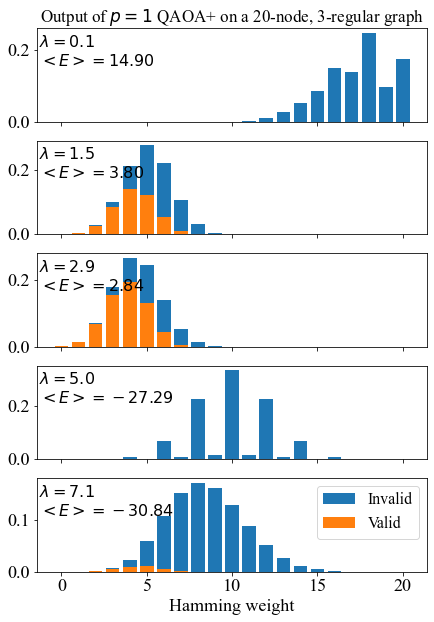

In [452]:
p = 1
n = 20
graph_type = 'd3'
graph_name = 'G12'
rep_name = 'rep5'
optimized_output_distribution(p, n, graph_type, graph_name, rep_name,
                              limited_lambda=[0.1, 1.5, 2.9, 5.0, 7.1],
                              savefig=f"figures/N{n}_{graph_type}_{graph_name}_{rep_name}_p{p}_output.pdf")

### Plot the sum total probability of valid and invalid states as a function of $\lambda$
In this case we can average over multiple reps and graphs - the summed probabilities will NOT sum to 1, but should give a general sense of what the output distributions are doing.

In [475]:
def get_row_data(row_data):
    lamda = row_data['lambda']
    p = row_data['p']
    graph_type = row_data['graph_type']
    graph_name = row_data['graph_name']
    rep_name = row_data['rep_name']
    N = row_data['N']
    
    dirname = f"benchmark_results/QAOA+_output_distributions/P{p}_{graph_type}/{graph_name}_{rep_name}"
    with open(f"{dirname}/hamming_histogram_lambda_{lamda}.pickle", "rb") as pklfile:
        hamming_histogram = pickle.load(pklfile)
    with open(f"{dirname}/top_100strings_lambda_{lamda}.pickle", "rb") as pklfile:
        top_strings = pickle.load(pklfile)
        
    # For the top strings we have to go through and label them as valid and invalid MIS states
    G = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N{N}_{graph_type}_graphs/{graph_name}.txt")
    top_strings_w_bool = []
    for bitstr, probability in top_strings:
        top_strings_w_bool.append((bitstr, probability, qcopt.graph_funcs.is_indset(bitstr, G)))

    return hamming_histogram, top_strings_w_bool

def summed_probabilities(p, N, graph_type):
    df = pd.read_csv("benchmark_results/QAOA+_expectation_values/all_d3_data.csv", usecols=[1,2,3,4,5,6,7])
    df.drop_duplicates(inplace=True)

    cur_data = df.loc[(df['p'] == p) & (df['N'] == N) & (df['graph_type'] == graph_type)]
    xvals = sorted(list(set(cur_data['lambda'])))
    yvals_valid, stderrs_valid = [], []
    yvals_invalid, stderrs_invalid = [], []
    for lambda_val in xvals:
        row_data = cur_data.loc[cur_data['lambda'] == lambda_val]
        temp_valid_sums = []
        temp_invalid_sums = []
        for i in range(row_data.shape[0]):
            hamming_histogram, top_strings = get_row_data(row_data.iloc[i])
            valid_sum = sum([v['valid'] for v in hamming_histogram.values()])
            invalid_sum = sum([v['invalid'] for v in hamming_histogram.values()])
            #print(f"\tThe sum total probability of valid states: {valid_sum}")
            #print(f"\tThe sum total probability of invalid states: {invalid_sum}")
            temp_valid_sums.append(valid_sum)
            temp_invalid_sums.append(invalid_sum)

        yvals_valid.append(np.mean(temp_valid_sums))
        stderrs_valid.append(np.std(temp_valid_sums) / np.sqrt(len(temp_valid_sums)))

        yvals_invalid.append(np.mean(temp_invalid_sums))
        stderrs_invalid.append(np.std(temp_invalid_sums) / np.sqrt(len(temp_invalid_sums)))
        
    return xvals, yvals_valid, stderrs_valid, yvals_invalid, stderrs_invalid

def plot_summed_probabilities(all_data, savefig=None):
    fig, ax = plt.subplots(dpi=200)
    
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(all_data))))
    #if savefig:
    #    color = iter(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
    for xvals, yvals_valid, stderr_valid, yvals_invalid, stderr_invalid, label in all_data:
        cur_color = next(color)
        ax.errorbar(xvals, yvals_valid, yerr=stderr_valid, capsize=1, elinewidth=0.5, lw=1.5, color=cur_color, label=f"{label}, valid")
        ax.errorbar(xvals, yvals_invalid, yerr=stderr_invalid, capsize=1, elinewidth=0.5, lw=1.5, color=cur_color, ls=':', label=f"{label}, invalid")
    
    ax.legend(fontsize=7, ncol=2)
    ax.set_xlabel('$\lambda$')
    ax.set_title('Total probability of valid and invalid states')
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

In [281]:
summed_data = []
for p in [1,2,3,4,5,6,7]:
    summed_data.append((*summed_probabilities(p, 20, 'd3'), f"$p={p}$"))

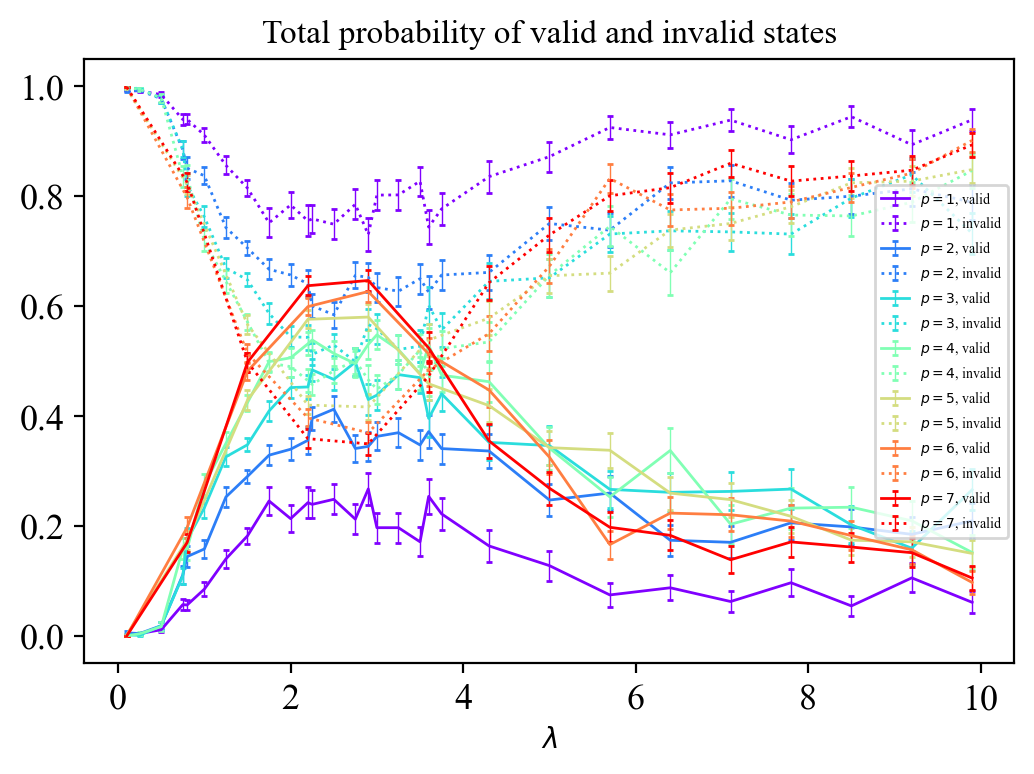

In [295]:
plot_summed_probabilities(summed_data)

### Paper plot

In [456]:
summed_data = []
for p in [1,3,5,7]:
    summed_data.append((*summed_probabilities(p, 20, 'd3'), f"$p={p}$"))

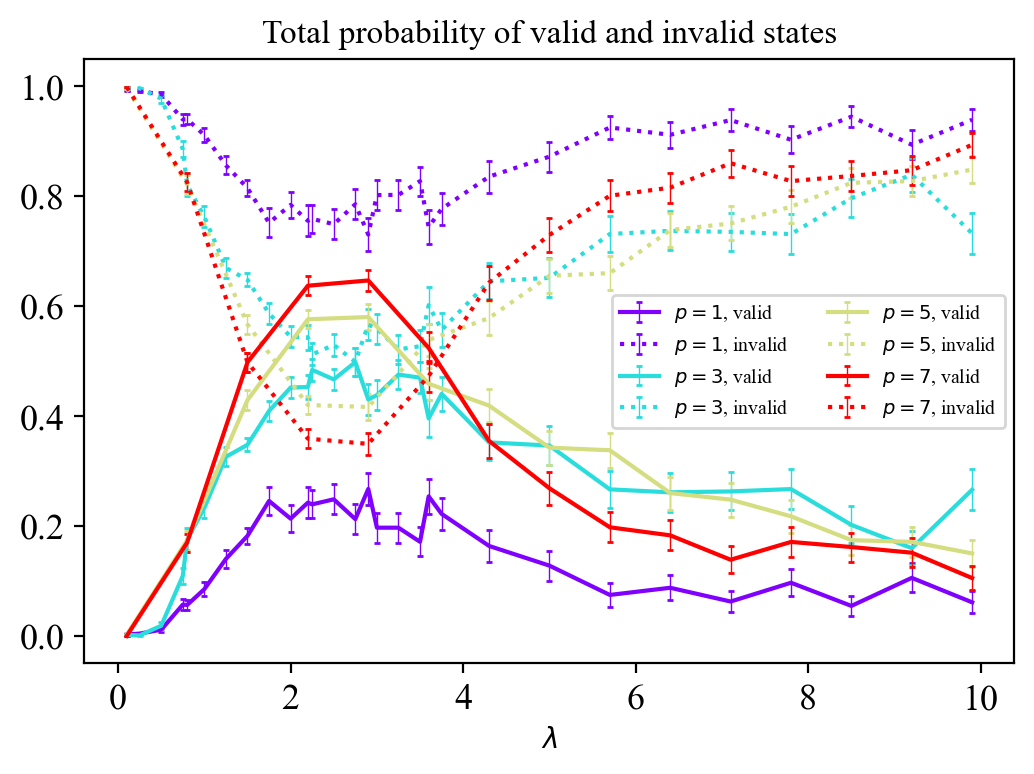

In [476]:
plot_summed_probabilities(summed_data, savefig="figures/summed_probability.pdf")

# Output distribution of the QAOA with random parameters

In [141]:
def gen_hamming_hist(G, params):
    backend = qiskit.Aer.get_backend("aer_simulator_statevector")
    circ = qcopt.ansatz.qaoa_plus.construct_qaoa_plus(int(len(params)/2), G, params, measure=False)
    probs = qiskit.quantum_info.Statevector(circ).probabilities_dict(decimals=7)
    
    hamming_histogram = get_output_dist_dict(probs, G)
    hamming_weights = sorted(list(hamming_histogram.keys()))
        
    fig, ax = plt.subplots(dpi=100)
    
    # Plot the invalid bars first, height = prob_valid + prob_invalid
    invalid_heights = [sum(hamming_histogram[hw].values()) for hw in hamming_weights]
    ax.bar(hamming_weights, invalid_heights, label='Invalid')

    # Plot the valid bars second (so they are in front), height = prob_valid
    valid_heights = [hamming_histogram[hw]['valid'] for hw in hamming_weights]
    ax.bar(hamming_weights, valid_heights, label='Valid')
    
    # Plot the mean Hamming weight
    mean_hamming_weight = 0
    for hw in hamming_weights:
        mean_hamming_weight += hw * (sum(hamming_histogram[hw].values()))
        
    ax.axvline(x=mean_hamming_weight, c='r', ls='--')

    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)

    ax.legend(loc='upper right', fontsize=16)
    ax.set_xlabel('Hamming weight', fontsize=18)
    
    #if savefig:
    #    plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

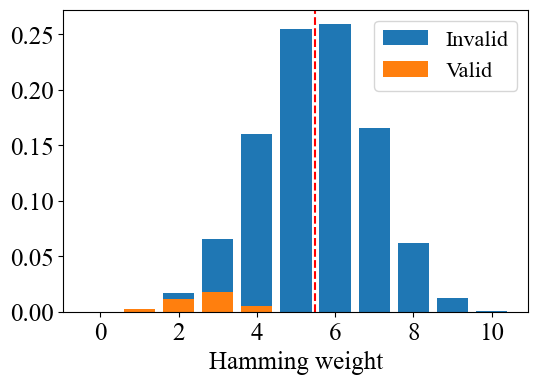

In [153]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N10_d3_graphs/G2.txt')
P = 1
params = np.random.uniform(low=0.0, high=2*np.pi, size=2*P)
gen_hamming_hist(G, params)

# Loss Landscape as a function of $\lambda$
Let's focus on $N=10$ node graphs, and $p=1$ for simplicity. We'd like to investigate the loss landscape for the MIS problem, and in particular
we want to know what the probability of sampling valid vs. invalid states is at different locations in the landscape.

## Landscape of valid vs invalid probabilities

In [237]:
def get_state_probabilities(G, beta, gamma):
    circ = qcopt.ansatz.qaoa_plus.construct_qaoa_plus(1, G, [gamma, beta], measure=False)
    probs = qiskit.quantum_info.Statevector(circ).probabilities_dict(decimals=7)
    
    hamming_histogram = get_output_dist_dict(probs, G)
    
    valid_sum = sum([v['valid'] for v in hamming_histogram.values()])
    invalid_sum = sum([v['invalid'] for v in hamming_histogram.values()])
    
    return valid_sum, invalid_sum

def generate_loss_landscape(G, step_size=0.2):
    beta = np.arange(0, 2*np.pi, step_size) # X axis
    gamma = np.arange(0, 2*np.pi, step_size)[::-1] # Y axis
    X, Y = np.meshgrid(beta, gamma)
    extent = np.min(beta), np.max(beta), np.min(gamma), np.max(gamma)
    
    valid_probability = []
    invalid_probability = []
    for x_row, y_row in zip(X, Y):
        new_row_valid = []
        new_row_invalid = []
        for x_val, y_val in zip(x_row, y_row):
            valid_sum, invalid_sum = get_state_probabilities(G, x_val, y_val)
            new_row_valid.append(valid_sum)
            new_row_invalid.append(invalid_sum)
        valid_probability.append(new_row_valid)
        invalid_probability.append(new_row_invalid)
    valid_probability = np.array(valid_probability)
    invalid_probability = np.array(invalid_probability)
    
    return valid_probability, invalid_probability, extent

def plot_loss_landscape(valid, invalid, extent, savefig=None):
    fig, ax = plt.subplots(dpi=250, nrows=2, ncols=1, sharex=True)
    
    im = ax[0].imshow(valid, extent=extent, vmin=0, vmax=1)
    im = ax[1].imshow(invalid, extent=extent, vmin=0, vmax=1)
    
    fig.colorbar(im, ax=ax.ravel().tolist())
    
    ax[0].tick_params(axis='y', labelsize=12)
    ax[1].tick_params(axis='x', labelsize=12)
    ax[1].tick_params(axis='y', labelsize=12)

    ax[1].set_xlabel(r'$\beta$', fontsize=12)
    ax[1].set_ylabel(r'$\gamma$', fontsize=12)
    ax[0].set_ylabel(r'$\gamma$', fontsize=12)
    
    ax[0].set_title('$P_{valid}$', fontsize=12)
    ax[1].set_title('$P_{invalid}$', fontsize=12)
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

In [182]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N10_d3_graphs/G2.txt')
step_size=0.2
valid, invalid, extent = generate_loss_landscape(G, step_size=step_size)

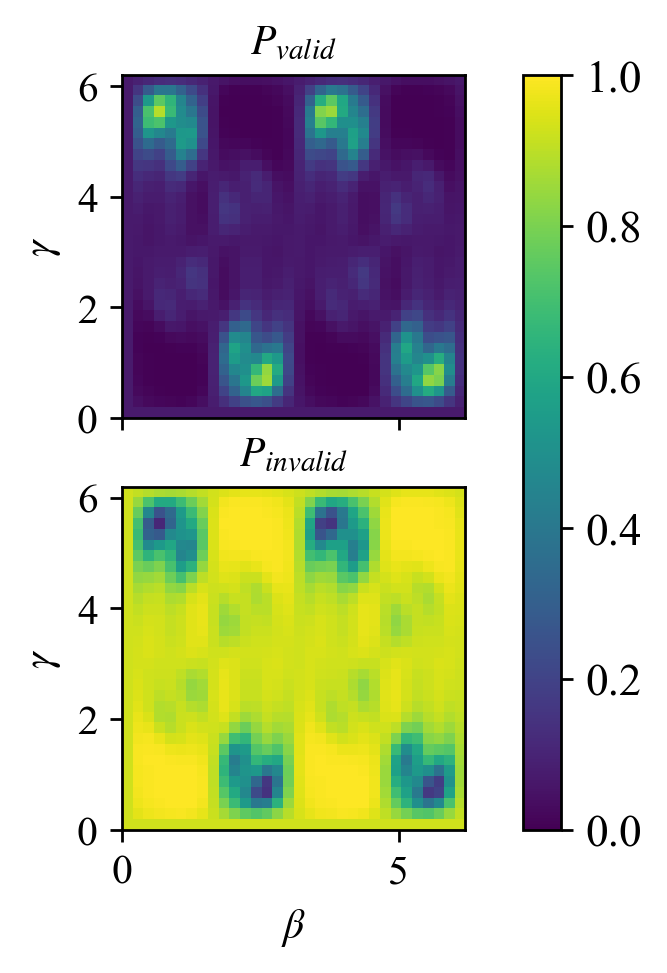

In [238]:
plot_loss_landscape(valid, invalid, extent, savefig='figures/test_landscape.pdf')

## Full loss landscape: $C_{obj} = \sum_{i \in V} b_i - \lambda \sum_{i,j \in E} b_i b_j$

In [250]:
def get_objective_function(G, beta, gamma, Lambda):
    circ = qcopt.ansatz.qaoa_plus.construct_qaoa_plus(1, G, [gamma, beta], measure=False)
    probs = qiskit.quantum_info.Statevector(circ).probabilities_dict(decimals=7)
    
    expected_val = 0
    for bitstr, probability in probs.items():
        temp_energy = qcopt.helper_funcs.hamming_weight(bitstr)
        for i, j in G.edges():
            rev_bitstr = list(reversed(bitstr))
            if rev_bitstr[i] == "1" and rev_bitstr[j] == "1":
                temp_energy -= Lambda
        expected_val += probability * temp_energy
        
    return expected_val

def generate_Cobj_loss_landscape(G, step_size=0.2, Lambda=2.5):
    beta = np.arange(0, 2*np.pi, step_size) # X axis
    gamma = np.arange(0, 2*np.pi, step_size)[::-1] # Y axis
    X, Y = np.meshgrid(beta, gamma)
    extent = np.min(beta), np.max(beta), np.min(gamma), np.max(gamma)
    
    obj_func = []
    for x_row, y_row in zip(X, Y):
        new_row = []
        for x_val, y_val in zip(x_row, y_row):
            new_row.append(get_objective_function(G, x_val, y_val, Lambda))
        obj_func.append(new_row)
    obj_func = np.array(obj_func)
    
    return obj_func, extent

def plot_Cobj_loss_landscape(obj_func, extent, savefig=None):
    fig, ax = plt.subplots(dpi=250)
    
    im = ax.imshow(obj_func, extent=extent)
    
    fig.colorbar(im, ax=ax)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    ax.set_xlabel(r'$\beta$', fontsize=12)
    ax.set_ylabel(r'$\gamma$', fontsize=12)
    
    ax.set_title('$<C_{obj}>$', fontsize=12)
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
    
    plt.show()
    plt.close()

### Small regime: $\lambda \approx 0.1$

In [259]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N20_d3_graphs/G2.txt')
step_size=0.2
small_regime, extent = generate_Cobj_loss_landscape(G, step_size=step_size, Lambda=0.1)

KeyboardInterrupt: 

In [ ]:
plot_Cobj_loss_landscape(small_regime, extent, savefig='figures/Cobj_loss_small.pdf')

### Middle regime: $\lambda \approx 2$

In [ ]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N20_d3_graphs/G2.txt')
step_size=0.2
middle_regime, extent = generate_Cobj_loss_landscape(G, step_size=step_size, Lambda=2.5)

In [ ]:
plot_Cobj_loss_landscape(middle_regime, extent, savefig='figures/Cobj_loss_medium.pdf')

### Large regime: $\lambda \approx 10$

In [ ]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N20_d3_graphs/G2.txt')
step_size=0.2
large_regime, extent = generate_Cobj_loss_landscape(G, step_size=step_size, Lambda=10)

In [ ]:
plot_Cobj_loss_landscape(large_regime, extent, savefig='figures/Cobj_loss_large.pdf')

# Pruning trials which failed to optimize